In [ ]:
%run training_theme_classification

In [1]:
import torch 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
import os
os.chdir('..')

In [14]:
import pandas as pd
df = pd.read_csv('Data/articles_actualite.csv')

In [15]:
score = pd.read_csv('Annotations/scores.csv')

In [16]:
score.shape

(116, 10)

In [17]:
df_merged = df.merge(score, on="identifiant", how="left")

In [18]:
df_merged = df_merged[~df_merged["score"].isna()]

In [19]:
df_merged.drop(columns = ['Unnamed: 0', 'theme'])

,identifiant,journal_clean,titre,annee,mois,jour,texte,keywords,theme_final,score,voc_violence,hierar,portrait_victime,portrait_auteur,relation,meanisme_violence,stat
40,efee09cde26fba5704002a3180ab0bf7f2f711dbff957d...,Le Figaro,Rennes : nouveau meurtre,1998,1,19,"« Ici, samedi 6 heures, une femme de 38 ans as...","violence, meurtre, rennes, femme, samedi",actualité,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
41,efee09cde26fba5704002a3180ab0bf7f2f711dbff957d...,Le Figaro,Rennes : nouveau meurtre,1998,1,19,"« Ici, samedi 6 heures, une femme de 38 ans as...","violence, meurtre, rennes, femme, samedi",actualité,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
42,d183794139b099c8c366eb2482b740f413f22d62bb7d6d...,Le Figaro,Une femme médecin assassinée,1998,1,21,"- Une femme de 60 ans, médecin allergologue, a...",NaN,actualité,-0.142857,0.0,1.0,1.0,0.0,-1.0,-1.0,-1.0
43,d183794139b099c8c366eb2482b740f413f22d62bb7d6d...,Le Figaro,Une femme médecin assassinée,1998,1,21,"- Une femme de 60 ans, médecin allergologue, a...",NaN,actualité,-0.142857,0.0,1.0,1.0,0.0,-1.0,-1.0,-1.0
44,00627f5991ec8312f034b90a05650e755e28a6a8109170...,Le Figaro,Le fils du médecin interpellé,1998,1,22,"- Le fils d'une femme médecin, assassinée chez...",fils,actualité,-0.285714,0.0,-1.0,0.0,0.0,1.0,-1.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4183,95e73c8deb87930f7c9352e69b3da1b8f06f86cbb239fd...,Libération,Haut-Rhin : une femme tuée par son ex-compagno...,2024,5,19,Une femme de 33 ans est morte à l'hôpital aprè...,"police, soir, volontairement, morte, services,...",actualité,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4236,c5c6f772f16b66b663a17995ed189c2ff7fb9902c0df8f...,Le Monde,#metoo des armées : un sergent-chef coupable d...,2024,6,20,"C’est un jugement marquant, d’une sévérité rar...","prison_avec_sursis, sergent-chef, prison, sexu...",actualité,0.857143,1.0,1.0,1.0,1.0,1.0,1.0,0.0
4299,cb52acd1ce6b9dc7210c42d6a7ab59ce133741137a2547...,Libération,Inde : choc et colère aprèsun nouveau féminicide,2024,8,16,"Des bougies, des femmes par milliers, des marc...","justice, nuit, femmes",actualité,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4432,b2a4e0f965f89ec54af1a183a71581de3913f47faf9299...,Le Nouvel Obs,Depardieu accusé d'agressions sexuelles : son ...,2024,10,28,"L'acteur Gérard Depardieu , visé par de nombre...","accusé, agressions, procès, renvoi, acteur, se...",actualité,0.857143,1.0,1.0,1.0,1.0,0.0,1.0,1.0


In [23]:
df_merged["texte_total"] = df_merged["titre"].fillna("") + " " + df_merged["texte"].fillna("")

label_cols = [
    "voc_violence", "hierar", "portrait_victime", "portrait_auteur",
    "relation", "meanisme_violence", "stat"
]


df_filtered = df_merged.dropna(subset=["texte_total", "score"] + label_cols)


from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(
    df_filtered,
    test_size=0.2,
    random_state=42
)

train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)


In [31]:
import torch
import torch.nn as nn
from transformers import CamembertModel
class CamembertMultiTaskModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = CamembertModel.from_pretrained("camembert-base")
        self.dropout = nn.Dropout(0.3)
        self.hidden_size = self.backbone.config.hidden_size  # 768
        self.regressor = nn.Linear(self.hidden_size, 1)
        self.classifier = nn.Linear(self.hidden_size, 7)  # 7 variables à classer

    def forward(self, input_ids, attention_mask):
        outputs = self.backbone(input_ids=input_ids, attention_mask=attention_mask)
        cls_embedding = self.dropout(outputs.last_hidden_state[:, 0, :])

        score = self.regressor(cls_embedding).squeeze(1)
        class_logits = self.classifier(cls_embedding)  # shape: [batch, 7]

        return score, class_logits


In [40]:
from torch.utils.data import Dataset

class MultiTaskDataset(Dataset):
    def __init__(self, df, tokenizer, max_length=256):
        self.df = df.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        text = str(self.df.iloc[idx]["texte_total"])
        inputs = self.tokenizer(
            text,
            padding="max_length",
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt"
        )

        item = {
            "input_ids": inputs["input_ids"].squeeze(0),
            "attention_mask": inputs["attention_mask"].squeeze(0),
            "score": torch.tensor(self.df.iloc[idx]["score"], dtype=torch.float),
            "class_labels": torch.tensor(
                self.df.iloc[idx][label_cols].values.astype(float),
                dtype=torch.float  # ou torch.long si tu veux une classification avec CrossEntropy
            )
        }

        return item


In [41]:
from transformers import CamembertTokenizer
from torch.utils.data import DataLoader

tokenizer = CamembertTokenizer.from_pretrained("camembert-base")
train_dataset = MultiTaskDataset(train_df, tokenizer)
test_dataset = MultiTaskDataset(test_df, tokenizer)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [42]:
from tqdm import tqdm
model = CamembertMultiTaskModel().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

loss_reg = nn.MSELoss()
loss_cls = nn.MSELoss()  # ou BCEWithLogitsLoss() / CrossEntropy si tu encodes autrement
num_epochs = 30

for epoch in tqdm(range(num_epochs)):
    model.train()
    total_loss = 0

    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels_score = batch['score'].to(device)
        labels_cls = batch['class_labels'].to(device)

        pred_score, pred_cls = model(input_ids, attention_mask)

        loss1 = loss_reg(pred_score, labels_score)
        loss2 = loss_cls(pred_cls, labels_cls)

        loss = loss1 + loss2

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()


100%|██████████| 30/30 [03:12<00:00,  6.42s/it]


In [43]:
from sklearn.metrics import mean_squared_error, r2_score

model.eval()
all_scores = []
all_preds = []
all_true = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels_score = batch['score'].to(device)
        labels_class = batch['class_labels'].to(device)

        pred_score, pred_class = model(input_ids, attention_mask)

        all_scores.extend(pred_score.cpu().numpy())
        all_preds.extend(pred_class.cpu().numpy())
        all_true.extend(labels_class.cpu().numpy())
        
# Évaluer la régression
mse = mean_squared_error(test_df["score"], all_scores)
r2 = r2_score(test_df["score"], all_scores)
print(f"Test — MSE: {mse:.4f} | R²: {r2:.4f}")


Test — MSE: 0.1165 | R²: 0.4295


In [44]:
from sklearn.metrics import classification_report
import numpy as np

y_pred = np.round(np.array(all_preds))  # logits → -1, 0, 1
y_true = np.array(all_true)

for i, col in enumerate(label_cols):
    print(f"\n--- {col} ---")
    print(classification_report(y_true[:, i], y_pred[:, i], digits=3, zero_division=0))



--- voc_violence ---
              precision    recall  f1-score   support

        -1.0      0.000     0.000     0.000         3
         0.0      0.611     0.846     0.710        13
         1.0      0.750     0.643     0.692        14

    accuracy                          0.667        30
   macro avg      0.454     0.496     0.467        30
weighted avg      0.615     0.667     0.631        30


--- hierar ---
              precision    recall  f1-score   support

        -1.0      0.000     0.000     0.000         7
         0.0      0.273     0.375     0.316         8
         1.0      0.632     0.800     0.706        15

    accuracy                          0.500        30
   macro avg      0.301     0.392     0.341        30
weighted avg      0.389     0.500     0.437        30


--- portrait_victime ---
              precision    recall  f1-score   support

        -1.0      0.000     0.000     0.000         3
         0.0      0.312     0.500     0.385        10
         1.

In [49]:
df_all = pd.read_csv("Data/articles_actualite.csv")
df_merged = df.merge(score, on="identifiant", how="left")
df_merged["texte_total"] = df_merged["titre"].fillna("") + " " + df_merged["texte"].fillna("")

In [50]:
df_annotated = df_merged[df_merged["score"].notna()].copy()
df_to_predict = df_merged[df_merged["score"].isna() & df_merged["texte_total"].notna()].copy()
df_to_predict = df_to_predict.reset_index()

In [52]:
predict_dataset = MultiTaskDataset(df_to_predict, tokenizer)
predict_loader = DataLoader(predict_dataset, batch_size=16, shuffle=False)

model.eval()
pred_scores = []
pred_labels = []

with torch.no_grad():
    for batch in tqdm(predict_loader):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)

        score, labels = model(input_ids, attention_mask)
        pred_scores.extend(score.cpu().numpy())
        pred_labels.extend(np.round(labels.cpu().numpy()))


100%|██████████| 271/271 [02:09<00:00,  2.10it/s]


In [56]:
original_idx = df_to_predict["index"]

# Injecter score uniquement si manquant
for i, idx in tqdm(enumerate(original_idx)):
    if pd.isna(df_merged.loc[idx, "score"]):
        df_merged.loc[idx, "score_pred"] = pred_scores[i]

# Injecter les variables uniquement si manquantes
for i, col in tqdm(enumerate(label_cols)):
    for j, idx in tqdm(enumerate(original_idx)):
        if pd.isna(df_merged.loc[idx, col]):
            df_merged.loc[idx, col + "_pred"] = pred_labels[j][i]


4332it [00:01, 2223.67it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
105it [00:00, 1047.64it/s]
276it [00:00, 1435.86it/s]
423it [00:00, 1451.21it/s]
615it [00:00, 1635.83it/s]
832it [00:00, 1826.26it/s]
1015it [00:00, 1703.52it/s]
1221it [00:00, 1813.95it/s]
1445it [00:00, 1944.87it/s]
1641it [00:00, 1937.68it/s]
1883it [00:01, 2081.60it/s]
2117it [00:01, 2158.16it/s]
2366it [00:01, 2257.22it/s]
2593it [00:01, 2259.03it/s]
2823it [00:01, 2271.18it/s]
3089it [00:01, 2385.59it/s]
3328it [00:01, 2344.28it/s]
3563it [00:01, 2231.28it/s]
3788it [00:01, 2158.17it/s]
4005it [00:01, 2111.31it/s]
4332it [00:02, 2003.61it/s]
1it [00:02,  2.18s/it]
0it [00:00, ?it/s]
204it [00:00, 2031.06it/s]
408it [00:00, 1922.46it/s]
601it [00:00, 1878.26it/s]
790it [00:00, 1858.99it/s]
991it [00:00, 1911.18it/s]
1183it [00:00, 1887.67it/s]
1372it [00:00, 1820.57it/s]
1616it [00:00, 2007.05it/s]
1866it [00:00, 2154.51it/s]
2114it [00:01, 2252.30it/s]
2349it [00:01, 2281.48it/s]
2595it [00:01, 2334.74it/s]
2830it

In [57]:
df_merged["score_final"] = df_merged["score"].fillna(df_merged["score_pred"])
for col in label_cols:
    df_merged[col + "_final"] = df_merged[col].fillna(df_merged[col + "_pred"])



In [59]:
final_cols = [
    "identifiant", "journal_clean", "titre", "annee", "mois", "jour", "texte_total",
    "score_final"
] + [col + "_final" for col in label_cols]

# Création du DataFrame réduit
df_final = df_merged[final_cols].copy()


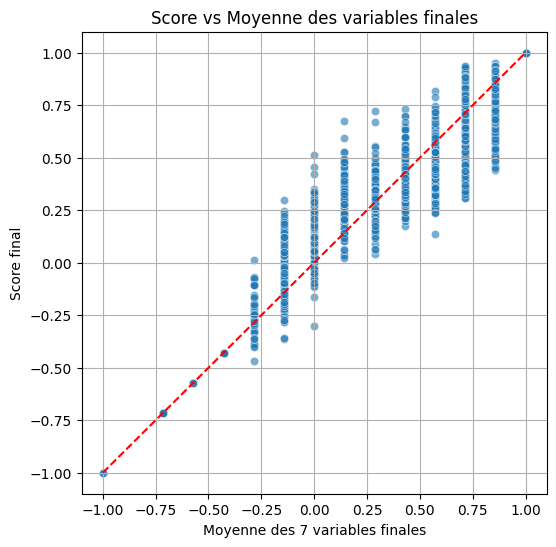

In [64]:
# 1. Calcul de la moyenne des 7 variables *_final pour chaque article
df_final["mean_variables"] = df_final[[col + "_final" for col in label_cols]].mean(axis=1)

# 2. Comparer avec le score final
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6, 6))
sns.scatterplot(data=df_final, x="mean_variables", y="score_final", alpha=0.6)
plt.plot([-1, 1], [-1, 1], 'r--')  # ligne diagonale parfaite
plt.xlabel("Moyenne des 7 variables finales")
plt.ylabel("Score final")
plt.title("Score vs Moyenne des variables finales")
plt.grid(True)
plt.savefig("score_vs_moyenne_variables.png", dpi=300, bbox_inches="tight")

plt.show()

In [62]:
df_final

,identifiant,journal_clean,titre,annee,mois,jour,texte_total,score_final,voc_violence_final,hierar_final,portrait_victime_final,portrait_auteur_final,relation_final,meanisme_violence_final,stat_final,mean_variables
0,3a4723d9d754ca30c68ba8e420cd6683548f2af7ff7af3...,Libération,Viol collectif dans la nuit de la Saint-Sylves...,1995,1,6,Viol collectif dans la nuit de la Saint-Sylves...,0.620987,1.0,1.0,1.0,1.0,1.0,0.0,-0.0,0.714286
1,2b6ce23c0fbfd6e213b7cd196a4b12eda4323e322f5f35...,Libération,"En Moselle, une jeune femme tuée par son mari",1995,1,16,"En Moselle, une jeune femme tuée par son mari ...",0.195183,0.0,1.0,0.0,0.0,1.0,-0.0,-1.0,0.142857
2,2293f5c041bec1dcdfe52bbe2655e0bec9a449310f534b...,Libération,Narbonne: une femme tuée après une fusillade. ...,1995,4,11,Narbonne: une femme tuée après une fusillade. ...,0.391785,0.0,1.0,1.0,1.0,1.0,0.0,-0.0,0.571429
3,2e9c275968c7996e9407977dfb6aaacd7141ac5e7ed0a2...,Libération,Une femme enceinte agressée par des vigiles au...,1995,4,17,Une femme enceinte agressée par des vigiles au...,0.476032,1.0,1.0,1.0,1.0,1.0,0.0,-0.0,0.714286
4,b1987151ea7e9e657b7207398a434df106c3a9d8d3c709...,Libération,Une femme blesse son ex-ami avant de se suicider,1995,9,18,Une femme blesse son ex-ami avant de se suicid...,-0.051603,0.0,1.0,0.0,0.0,0.0,-0.0,-1.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4477,a3c235da28477a6045b1e97abd2b5491b1aa772c273ae4...,Libération,Me Too : Harvey Weinstein hospitalisé après de...,2024,12,3,Me Too : Harvey Weinstein hospitalisé après de...,0.708056,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.714286
4478,377988b4b18f66bdf316259434127bc49e39ac016edacd...,Le Figaro,Italie: un homme condamné à la prison à vie po...,2024,12,3,Italie: un homme condamné à la prison à vie po...,0.595197,1.0,0.0,1.0,1.0,1.0,0.0,-0.0,0.571429
4479,1a7689437dc0d5a11e37df86ddd7d9ea4c37195a7ecdbc...,Le Point,Harvey Weinstein est de nouveau hospitalisé,2024,12,4,Harvey Weinstein est de nouveau hospitalisé Ha...,0.721072,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.857143
4480,20d7c133c259fe5e149d1cddfa8be63aa616233362596f...,Le Figaro,«Adèle Haenel et ses 12 ans étaient d’une sens...,2024,12,4,«Adèle Haenel et ses 12 ans étaient d’une sens...,0.781516,1.0,0.0,1.0,1.0,1.0,1.0,-0.0,0.714286
